In [22]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

#### Historical ERA5 RH

In [23]:
#Surface data
t2mData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).t2m
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).d2m


# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'rh' (dayofyear: 63)>
array([7.83735371, 7.2224226 , 6.82293844, 6.33095407, 6.57690048,
       6.7033987 , 5.63456917, 6.27240086, 6.24246836, 6.34956932,
       6.46910715, 6.91903973, 7.82203293, 8.22634602, 8.09963894,
       8.23625469, 8.80352306, 8.53283978, 7.85161686, 7.81457615,
       8.09376526, 7.91038561, 7.74540901, 7.64857769, 8.05025005,
       8.32816696, 7.79629755, 8.39619541, 8.42744446, 8.85504532,
       9.19669342, 5.93452597, 5.89165878, 5.70545292, 5.7599678 ,
       5.9994483 , 5.89557648, 6.20635509, 6.82581091, 7.63055229,
       6.99656916, 7.1467452 , 7.73572636, 7.21030903, 6.49805164,
       6.90001297, 7.59198332, 7.11872005, 6.80960035, 6.77130365,
       7.29553556, 7.48265553, 7.6647296 , 7.76842928, 7.8550396 ,
       7.73076487, 7.42575693, 6.94417477, 6.78639793, 6.68396091,
       7.15911627, 7.71136093, 3.488518  ])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

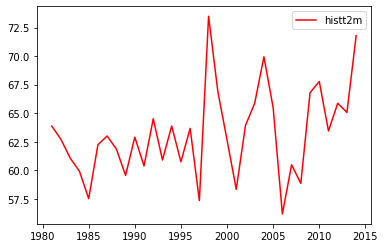

In [24]:


#Calculate rh
rh = (e**((17.625*(d2mD.values-273.15))/(243.04+(d2mD.values-273.15)))/e**((17.625*(t2mD.values-273.15))/(243.04+(t2mD.values-273.15)))*100.0)
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})

rh_ds.attrs
rh_ds.attrs['units']='%'
rh_ds.attrs['long_name']='2m Relative humidity'


# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask


# Area Average
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh

rhTs=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
# # Historical Moisture
x=np.arange(1981,2015)
ObsERA5=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T09:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T09:00:00')
   # print(EnDString)
    rhT=rhTs.sel(time=slice(InDString,EnDString))
    #print(rhT.time)
    ObsERA5.append(rhT.mean())
    
    #print(yr)

#print(y)
plt.plot(x,ObsERA5,label='histt2m', color='red')
plt.legend()


rhHistMean1=rhTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]

rhERA5HistMean=rhTs.groupby('time.dayofyear').mean()
rhERA5HistMean
rhERA5HistStd=rhTs.groupby('time.dayofyear').std()
rhERA5HistStd


[46.405945 46.373646 47.49052  ... 64.187996 61.724712 59.635265]


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


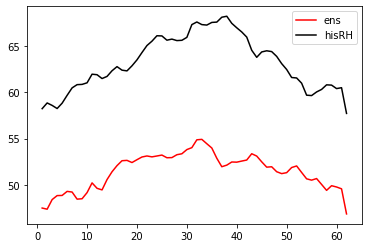

In [25]:
### Historical model BC

# IPSL

rhData  = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_hurs_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../Data/CMIP6/EC-Earth3/processed/Regrid_hurs_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../Data/CMIP6/ACCESS-CM2/hursNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS


# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=ensTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH_ens=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')

#plt.ylim([275, 295])
plt.legend()




In [26]:

MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS

ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean


[46.405945 46.373646 47.49052  ... 64.187996 61.724712 59.635265]


<xarray.DataArray 'rh' (dayofyear: 63)>
array([54.02684 , 54.87179 , 54.91794 , 54.447388, 53.986996, 52.883675,
       51.970905, 52.141617, 52.479256, 52.462128, 52.57988 , 52.69113 ,
       53.37062 , 53.11801 , 52.498848, 51.92467 , 51.965454, 51.432365,
       51.227333, 51.32986 , 51.883408, 52.053383, 51.35251 , 50.666836,
       50.524353, 50.695206, 50.062435, 49.423557, 49.924335, 49.78654 ,
       49.589584, 46.88496 , 47.51752 , 47.393944, 48.429794, 48.85906 ,
       48.875553, 49.312653, 49.242268, 48.47603 , 48.519817, 49.181526,
       50.22827 , 49.64344 , 49.473186, 50.585556, 51.425644, 52.088814,
       52.616962, 52.655342, 52.4205  , 52.72681 , 53.01823 , 53.129436,
       53.032314, 53.126595, 53.226   , 52.938564, 52.95391 , 53.263824,
       53.36624 , 53.817604, 58.963814], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

51.514783870110705


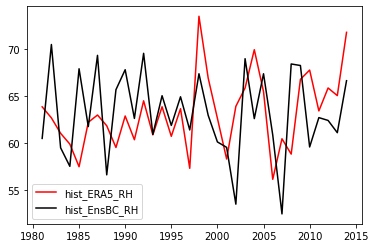

In [27]:

MTs=[]
for c in rhTsACCESS.time:
        
    MTs.append((rhTsACCESS.sel(time=c)+rhTsIPSL.sel(time=c)+
                rhTsEC.sel(time=c))/3.0)
    
ensFu=rhTsACCESS.copy()
ensFu.values=MTs


MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensFu=rhTsACCESS.copy()
ensFu.values=MTs

ensFuMean=ensFu.groupby('time.dayofyear').mean()
ensFuStd=ensFu.groupby('time.dayofyear').std()

### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
#print(ensFuBC)
#print(ensFu)

#print(ensFuBC)
#print(cnnObs)


x=np.arange(1981,2015)
EnsBCHist=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
    rhT=ensFuBC.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
    EnsBCHist.append(rhT.mean().values)
    
    #print(yr)

#print(y)

plt.plot(x,ObsERA5,label='hist_ERA5_RH', color='red')
plt.plot(x,EnsBCHist,label='hist_EnsBC_RH', color='black')
plt.legend()



/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


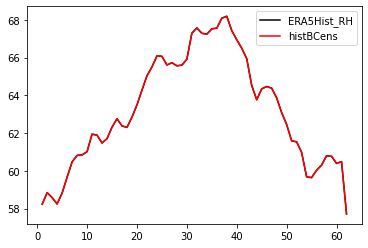

In [28]:
x=np.arange(1,63)
plt.plot(x,histRH,label='ERA5Hist_RH', color='black')
ensFuBCHistMean1=ensFuBC.groupby('time.dayofyear').mean()
ensFuBCHistMean2=ensFuBCHistMean1.roll(dayofyear=31)
histBCens=ensFuBCHistMean2[(ensFuBCHistMean2.dayofyear<366) | (ensFuBCHistMean2.dayofyear>366)]
plt.plot(x,histBCens,label='histBCens', color='red')
plt.legend()
plt.savefig('histEnsBCTS.eps')
plt.show()

df=ensFuBC.to_dataframe(name='histEnsBCTS')
#np.savetxt('histEnsTS.txt', df.values, fmt='%1.3f')



In [29]:
######### Future proj

In [30]:
ssps=['126','245','370','585']


fig = plt.figure(figsize=(10,7))

x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_rh')
plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp)


plt.legend()
plt.xlabel('Year') 
plt.ylabel('Relative Humidity %')
    
plt.savefig('rh_ts.eps')
plt.show()    
    #print(yr)



fig = plt.figure(figsize=(22.5,5))
i=1
#x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_rh')
#plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
    x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    plt.subplot(1, 4, i)
    x=np.arange(1981,2015)
    plt.plot(x,ObsERA5,label='hist_ERA5_rh',color='black')
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='black')
    plt.ylim(50,75)
    plt.xlabel('Year') 
    if i==1:
        plt.ylabel('Relative Humidity %')
    #plt.title('SSP'+sp)
    plt.axvline(x=2014,color='grey')
    i=i+1


#plt.legend()
#plt.xlabel('Year') 
#plt.ylabel('Relative Humidity %')
    
plt.savefig('rh_ts_panel.eps')
plt.show()    
    #print(yr)



fig = plt.figure(figsize=(22.5,5))
i=1
#x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_rh')
#plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
    x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    plt.subplot(1, 4, i)
    x=np.arange(1981,2015)
    plt.plot(x,ObsERA5,label='hist_ERA5_rh',color='grey')
    S = pd.Series (ObsERA5)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='grey')
    S = pd.Series (EnsBCFu)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xFu,rENS,label='SSP'+sp,color='black')
#print (df)
    plt.ylim(50,75)
    plt.xlabel('Year') 
    if i==1:
        plt.ylabel('Relative Humidity %')
    #plt.title('SSP'+sp)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()
#plt.xlabel('Year') 
#plt.ylabel('Relative Humidity %')
    
plt.savefig('rh_ts_panel_5ymean.eps')
plt.show()    
    #print(yr)

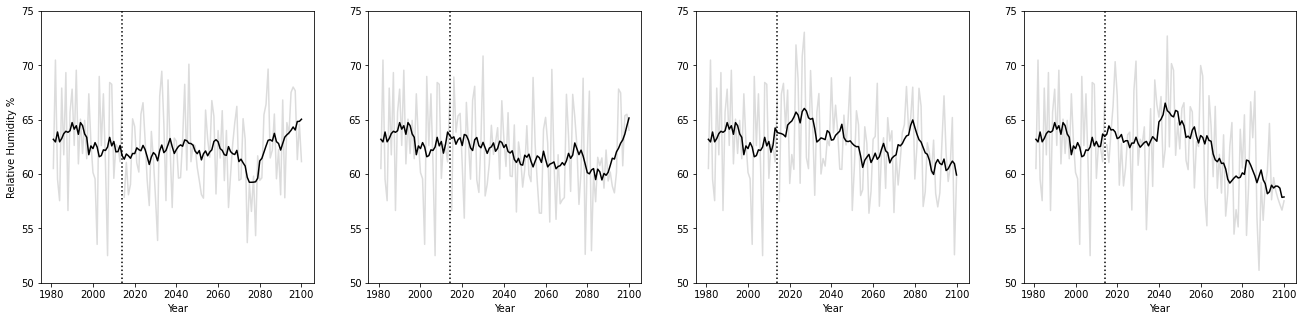

In [32]:

fig = plt.figure(figsize=(22.5,5))
i=1
#x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_rh')
#plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:
    
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='gainsboro')
    
    #print(EnsBCHist)


    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
    #x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    #plt.subplot(1, 4, i)
    #x=np.arange(1981,2015)
    #plt.plot(x,ObsERA5,label='hist_ERA5_rh',color='gainsboro')
    #S = pd.Series (ObsERA5)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(10, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
#print (df)
    plt.ylim(50,75)
    plt.xlabel('Year') 
    if i==1:
        plt.ylabel('Relative Humidity %')
    #plt.title('SSP'+sp)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()
#plt.xlabel('Year') 
#plt.ylabel('Relative Humidity %')
    
plt.savefig('rh_ts_panel_10yMean.eps')
plt.show()    
    #print(yr)

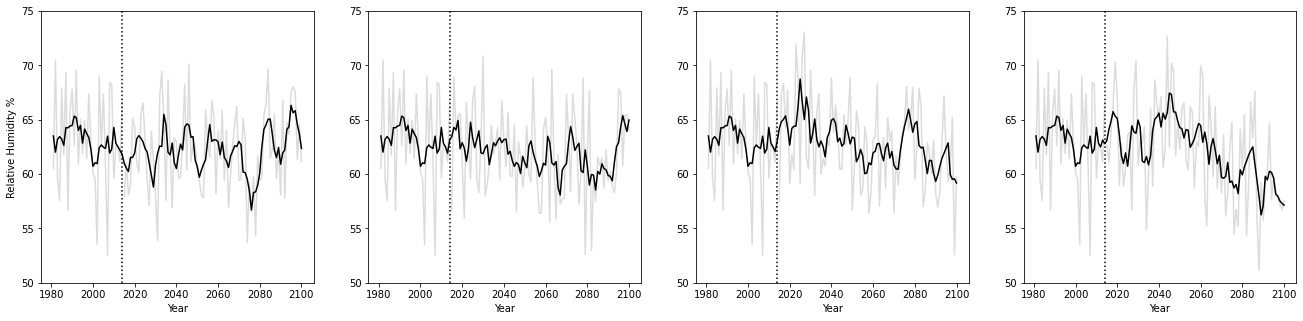

In [35]:
fig = plt.figure(figsize=(22.5,5))
i=1
#x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_rh')
#plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:
    
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='gainsboro')
    
    #print(EnsBCHist)


    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_hurs_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.hurs.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
    #x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    #plt.subplot(1, 4, i)
    #x=np.arange(1981,2015)
    #plt.plot(x,ObsERA5,label='hist_ERA5_rh',color='gainsboro')
    #S = pd.Series (ObsERA5)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
#print (df)
    plt.ylim(50,75)
    plt.xlabel('Year') 
    if i==1:
        plt.ylabel('Relative Humidity %')
    #plt.title('SSP'+sp)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()
#plt.xlabel('Year') 
#plt.ylabel('Relative Humidity %')
    
plt.savefig('rh_ts_panel_5yMean.eps')
plt.show()    
    #print(yr)